## Package Imports & Function Definitions

In [2]:
import os
import pickle
import time
from tqdm import tqdm
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, get_window
from scipy.sparse import csr_matrix
from scipy.io import loadmat
import pandas as pd
from datetime import datetime
import pywt
from concurrent.futures import ThreadPoolExecutor

plt.rcParams.update({'font.size': 14})


"""Definitions"""

def extract_time_from_filename(filename):
    # Returns the time the csv was recorded in microseconds
    parts = filename.split('_')
    return int(parts[-1].strip('.csv'))


def count_threshold_crossings(arr, threshold):
    # Create a boolean array where True indicates values above the threshold
    above_threshold = arr > threshold

    # Compute the difference between consecutive elements
    crossings = np.diff(above_threshold.astype(int))

    # Count the number of -1 to 1 crossings
    threshold_crossings = np.count_nonzero(crossings == 1)

    return threshold_crossings


def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

## Load Data

In [3]:
"""Get Waveform Folder From User"""

# Get the Mistras AE Waveforms filepath from the user
mistras_wfm_dir_root = ''
while mistras_wfm_dir_root == '':
    mistras_wfm_dir_root = input("Enter the directory of the Mistras AE waveforms: ")
    if os.path.isdir(mistras_wfm_dir_root):
        print(f"'{mistras_wfm_dir_root} is a valid directory. Continuing...")
        break
    else:
        print(f"'{mistras_wfm_dir_root} is not a valid directory. Try Again:")
        mistras_wfm_dir_root = ''


"""Get Waveform Metadata"""

# Waveforms to read from the waveforms folder
file_list = sorted([f for f in os.listdir(mistras_wfm_dir_root) if f.endswith('.csv')],
                   key=extract_time_from_filename)

dta_file_path_line_no = 1
dta_file_start_date_line_no = 2
dta_file_start_time_line_no = 3
sample_interval_line_no = 4
signal_units_line_no = 5
time_units_line_no = 6
data_points_per_waveform_line_no = 8
hit_time_line_no = 11
pre_trigger_line_no = 13
header_lines = 11

file_count = len(file_list)

# Get metadata about the waveforms by examining the header of the first file
metadata = {}

first_file_name = file_list[0]
first_file_path = os.path.join(mistras_wfm_dir_root, first_file_name)

last_file_name = file_list[-1]
last_file_path = os.path.join(mistras_wfm_dir_root, last_file_name)

# Extract the data after ":" in the string in the 1st column, 11th row
with open(first_file_path, 'r') as file:
    lines = file.readlines()

    dta_file_start_time_line = lines[dta_file_start_time_line_no - 1].strip().split(':', 1)
    dta_file_start_time_str = dta_file_start_time_line[1].strip()
    dta_file_start_time = datetime.strptime(dta_file_start_time_str, "%H:%M:%S")

    sample_interval_line = lines[sample_interval_line_no - 1].strip().split(':', 1)
    sample_interval = float(sample_interval_line[1].strip())
    AE_fs = 1 / sample_interval  # AE sampling frequency (Hz)

    signal_units_line = lines[signal_units_line_no - 1].strip().split(':', 1)
    signal_units = signal_units_line[1].strip()

    time_units_line = lines[time_units_line_no - 1].strip().split(':', 1)
    time_units = time_units_line[1].strip()

    data_points_per_waveform_line = lines[data_points_per_waveform_line_no - 1].strip().split(':', 1)
    data_points_per_waveform = int(data_points_per_waveform_line[1].strip())

    pre_trigger_line = lines[pre_trigger_line_no - 1].strip().split(',')
    pre_trigger_time = -float(pre_trigger_line[0].strip())

with open(last_file_path, 'r') as file:
    lines = file.readlines()

    hit_time_line = lines[hit_time_line_no - 1].strip().split(':', 1)
    last_hit_time = float(hit_time_line[1].strip())


"""Load Waveform Data"""

fs = AE_fs
window_length = int(data_points_per_waveform/2)
overlap = 0
# window = np.hanning(window_length)
window = get_window('hann', window_length)

# Initialize data arrays
data_matrix = np.zeros((data_points_per_waveform, file_count), dtype=float)
relative_hit_times = np.zeros(file_count, dtype=float)

pickled_data_matrix_filepath = mistras_wfm_dir_root + f'\\pickled_data_matrix.pkl'
pickled_relative_hit_times_filepath = mistras_wfm_dir_root + f'\\pickled_relative_hit_times.pkl'

# Load the arrays from the pickle files if they're saved
if os.path.isfile(pickled_data_matrix_filepath) and os.path.isfile(pickled_relative_hit_times_filepath):
    print(f"The data_matrix and relative_hit_times arrays exist in the directory. Loading.")

    with open(pickled_data_matrix_filepath, 'rb') as file:
        data_matrix = pickle.load(file)

    with open(pickled_relative_hit_times_filepath, 'rb') as file:
        relative_hit_times = pickle.load(file)

else:
    print("The data_matrix or relative_hit_times arrays do not exist in the directory.")
    print("Reading waveform files directly using a thread pool executor ->")

    def load_waveform(file_path):
        # Read the header to extract the hit time
        with open(file_path, 'r') as f:
            lines = f.readlines()
        hit_time_line = lines[hit_time_line_no - 1].strip().split(':')
        hit_time = float(hit_time_line[1].strip())
        # Load waveform data: skip header_lines and load using NumPy.
        # (Assumes the CSV data has at least two columns and that the second column contains the waveform.)
        data = np.loadtxt(file_path, delimiter=',', skiprows=header_lines)
        # Only take as many rows as data_points_per_waveform and extract column 1 (the second column)
        waveform = data[:data_points_per_waveform, 1]
        return waveform, hit_time

    # Create full file paths
    file_paths = [os.path.join(mistras_wfm_dir_root, fname) for fname in file_list]

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(load_waveform, file_paths),
                            total=len(file_paths),
                            desc="Loading waveforms"))

    # Combine results into arrays
    data_matrix = np.column_stack([waveform for waveform, _ in results])
    relative_hit_times = np.array([hit_time for _, hit_time in results])

    # Save the arrays to pickle files for future use
    with open(pickled_data_matrix_filepath, 'wb') as file:
        pickle.dump(data_matrix, file)
    with open(pickled_relative_hit_times_filepath, 'wb') as file:
        pickle.dump(relative_hit_times, file)

# # Verify that each column in data_matrix corresponds to the file in file_paths
# for i, path in enumerate(file_paths):
#     print(f"File {i}: {path}")
#     print("First five data points:", data_matrix[:5, i])
#     print("-" * 40)

"""Slice Waveform Data"""

# Have the user enter a time range of files to examine. Then, slice the data

starting_time = None
starting_file_index = None
ending_time = None
ending_file_index = None
slicing_range = ""
user_input = ''
while user_input == '':
    user_input = input("Enter the time range of files to analyze in seconds with a colon separating start and end times.\n"
                       "Ex: \"0:1100\" or \":4.55\" or \"600:\". Put nothing around the colon to indicate using all files -> \":\"\n").strip()

    time_bounds = user_input.split(':')

    try:
        starting_time_str = time_bounds[0]
        ending_time_str = time_bounds[1]

        if starting_time_str:
            starting_time = float(starting_time_str)
        if ending_time_str:
            ending_time = float(ending_time_str)
        break
    except Exception as e:
        if user_input == ':':
            break
        else:
            print(f"\n'{repr(user_input)} is not a valid entry: {e}\nTry again:")
            user_input = ''

# Determine the indices of file_list to slice on based on the start and end times
if starting_time is not None:
    starting_file_index = next((i for i, f in enumerate(file_list)
                                if extract_time_from_filename(f) >= starting_time * 1e6), 0)
else:
    starting_file_index = 0

if ending_time is not None:
    ending_file_index = next((i for i, f in enumerate(file_list)
                              if extract_time_from_filename(f) > ending_time * 1e6), len(file_list))
else:
    ending_file_index = len(file_list)

# Slice the data based on the calculated indices
if starting_time is not None or ending_time is not None:
    file_list = file_list[starting_file_index:ending_file_index]
    file_count = len(file_list)
    data_matrix = data_matrix[:, starting_file_index:ending_file_index]
    relative_hit_times = relative_hit_times[starting_file_index:ending_file_index]

'C:\Users\sapierso\Box\NED3_Share\Stephen Pierson\Partial Discharge Project\table_tap_preamp_one_usb_waveforms is a valid directory. Continuing...
The data_matrix or relative_hit_times arrays do not exist in the directory.
Reading waveform files directly using a thread pool executor ->


Loading waveforms: 100%|██████████| 414/414 [00:02<00:00, 200.42it/s]


## Plot the Spectrogram

Looping through file data...


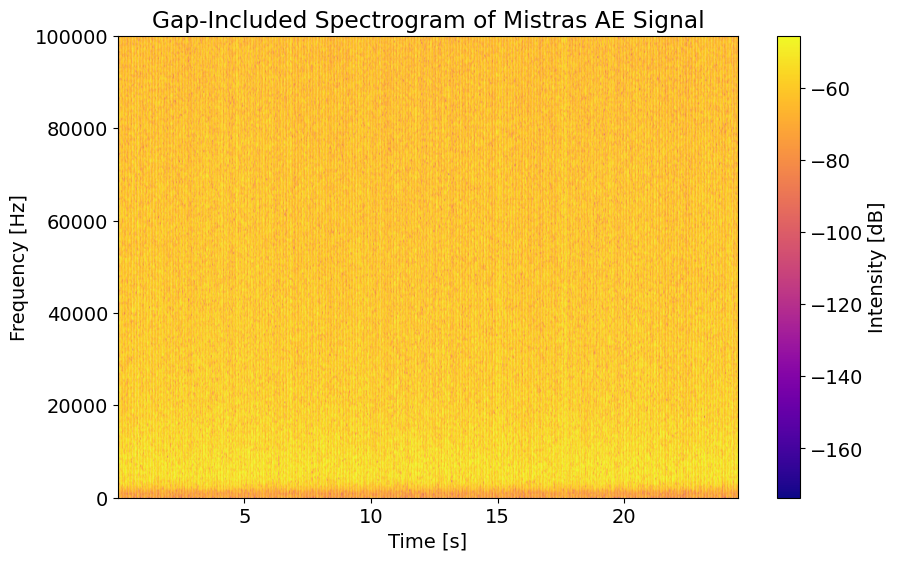

In [4]:
"""Get the AE threshold the Mistras DAQ was set at from the user"""

dB_AE_threshold = None
V_rms_threshold = None
user_input = ''
while user_input == '':
    user_input = input("Enter preset threshold (dB) for the Mistras file. Type 'None' to skip: ").strip()
    try:
        dB_AE_threshold = float(user_input)
        V_rms_threshold = pow(10, dB_AE_threshold / 20) * 100 * 10 ** -6
        break
    except:
        if user_input.lower() == 'none':
            break
        else:
            print(f"'{repr(user_input)} is not a valid number. Try Again.")
            user_input = ''


"""Plot spectrogram and reconstruct 'count' parameter"""

count = np.zeros(file_count, dtype=int)

plt.figure(figsize=(10, 6))

print("Looping through file data...")

# Loop to read each CSV file of each waveform
for i in range(len(relative_hit_times)):
    # If the arrays are not already loaded, load them
    # if not arrays_pickled:
    #     file_path = os.path.join(mistras_wfm_dir_root, file_name)
    #
    #     # Extract the data after ":" in the string in the 1st column, 11th row
    #     with open(file_path, 'r') as file:
    #         lines = file.readlines()
    #
    #     time_of_hit_line = lines[hit_time_line_no - 1].strip().split(':')
    #
    #     # Extract the time of the hit from the file and calculate the start time of the waveform samples
    #     hit_time = float(time_of_hit_line[1])
    #     start_time = hit_time - pre_trigger_time
    #
    #     # Convert hit start and end times to indices
    #     start_index = int(start_time * AE_fs)
    #     end_index = start_index + data_points_per_waveform
    #
    #     # Read the waveform data from the CSV
    #     df = pd.read_csv(file_path, header=None, usecols=[0, 1], skiprows=header_lines)
    #     data_chunk = df[1].values[:data_points_per_waveform]  # Extract the signal from the second column.
    #
    #     # Save the time-series data and the hit time to the arrays
    #     data_matrix[:, i] = data_chunk
    #     relative_hit_times[i] = hit_time

    start_time = relative_hit_times[i] - pre_trigger_time

    if V_rms_threshold is not None:
        count[i] = count_threshold_crossings(data_matrix[:, i], V_rms_threshold)
    else:
        count[i] = count_threshold_crossings(data_matrix[:, i], 0)

    f, t, Sxx = spectrogram(data_matrix[:, i], fs=fs, window=window)
    plt.pcolormesh(t + start_time, f, 10 * np.log10(Sxx), shading='gouraud', cmap='plasma')
    # if i == 0:
    #     break


plt.ylim([0, 100000])
plt.colorbar(label='Intensity [dB]')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Gap-Included Spectrogram of Mistras AE Signal')
plt.show()

## Construct Gap-Included Waveform

In [5]:
waveform_processing_start_time = time.time()

diff_timeInterv = np.diff(relative_hit_times)
if diff_timeInterv.size > 0:
    print(f"Biggest time gap between waveforms: {np.max(diff_timeInterv)}")

wfm_times = np.zeros(data_matrix.size + diff_timeInterv.size)
gap_included_wfm = np.zeros(data_matrix.size + diff_timeInterv.size)

idx = 0
for i in range(data_matrix.shape[1]):
    hit_time = relative_hit_times[i]
    wfm_times[idx:idx + data_points_per_waveform] = np.linspace(-pre_trigger_time + hit_time,
                                                                -pre_trigger_time + hit_time + data_points_per_waveform * sample_interval,
                                                                data_points_per_waveform)
    gap_included_wfm[idx:idx + data_points_per_waveform] = data_matrix[:, i]
    if i < data_matrix.shape[1] - 1:
        idx += data_points_per_waveform
        gap_included_wfm[idx] = np.nan
        idx += 1

total_waveform_processing_time = time.time() - waveform_processing_start_time
print(f"Total waveform processing time {total_waveform_processing_time}")

Biggest time gap between waveforms: 0.06219160000000201
Total waveform processing time 0.04973196983337402


## Plot the Raw Gap-Included Waveform

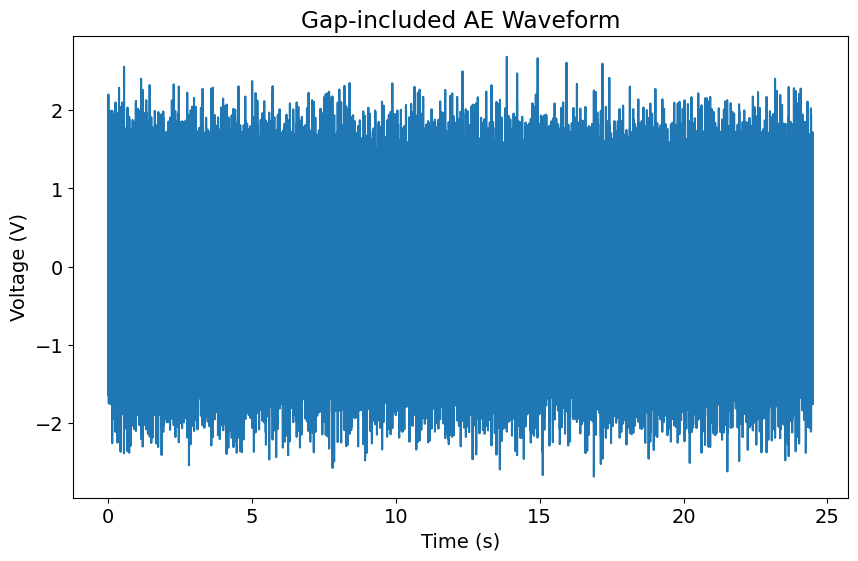

In [6]:
# Plot gap-included waveform
plt.figure(figsize=(10, 6))
# plt.xlim([.08, .09])
plt.plot(wfm_times, gap_included_wfm)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Gap-included AE Waveform")
if V_rms_threshold is not None:
    plt.axhline(y=V_rms_threshold, color='r', linestyle='--', label="Voltage Threshold Band")
    plt.axhline(y=-V_rms_threshold, color='r', linestyle='--')
    plt.legend()
plt.show()

moving_avg_window_size = 50
moving_avg = moving_average(count, window_size=moving_avg_window_size)
time_adjusted = relative_hit_times[moving_avg_window_size-1:]

# Plot "Count"

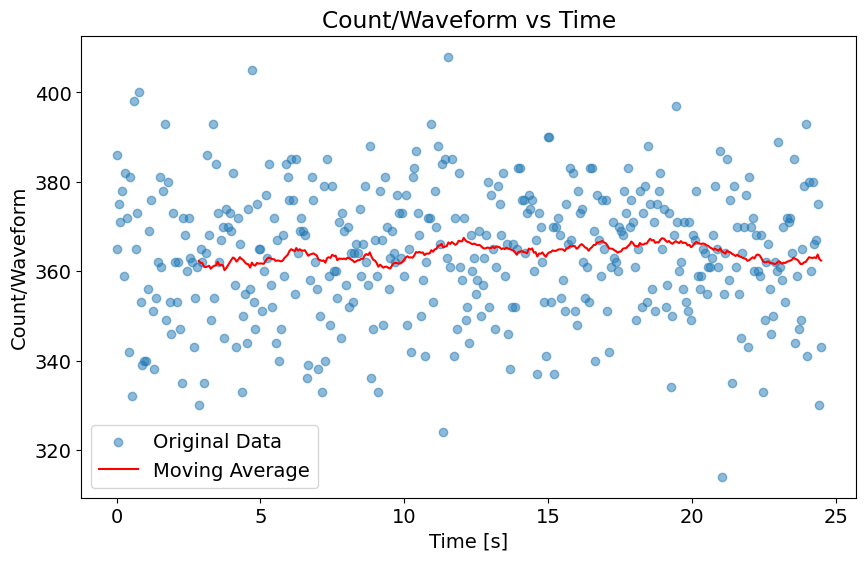

In [7]:
# Plot count/waveform vs time
plt.figure(figsize=(10, 6))
plt.scatter(relative_hit_times, count, label='Original Data', alpha=0.5)

# Determine whether there is enough data to include the moving average line
if time_adjusted.size > 0:
    plt.plot(time_adjusted, moving_avg, label='Moving Average', color='red')

plt.xlabel('Time [s]')
plt.ylabel('Count/Waveform')
plt.title('Count/Waveform vs Time')
plt.legend()
plt.show()

## Wavelet Analysis

In [8]:
"""CWT Analysis"""

# Find the indices where NaNs occur to split the data
nan_indices = np.where(np.isnan(gap_included_wfm))[0]

# Add 0 and the length of the array as split points
split_indices = np.concatenate(([0], nan_indices, [len(gap_included_wfm)]))

# Split the data into segments based on NaN positions
segments = [gap_included_wfm[split_indices[i]:split_indices[i+1]] for i in range(len(split_indices)-1)]
time_segments = [wfm_times[split_indices[i]:split_indices[i+1]] for i in range(len(split_indices)-1)]

# Initialize an empty list to collect all scalogram data. TODO: pickle as well?
scalograms = []

wavelet = 'cmor'

# Define the frequency range you want to capture
lowest_frequency = 10  # Hz (adjust this as needed)
highest_frequency = AE_fs/2  # Nyquist frequency

# Compute the normalized frequency range
lowest_frequency_normalized = lowest_frequency / AE_fs
highest_frequency_normalized = highest_frequency / AE_fs

# Calculate the corresponding scales
highest_scale = pywt.frequency2scale(wavelet, lowest_frequency_normalized)
lowest_scale = pywt.frequency2scale(wavelet, highest_frequency_normalized)

# Create a logarithmically-spaced scale array
num_scales = 32  # You can adjust this number
scales = np.logspace(np.log10(lowest_scale), np.log10(highest_scale), num_scales)

# for i, (seg_times, seg_wfm) in tqdm(enumerate(zip(time_segments, segments)), total=len(segments), desc="Processing Segments"):
#     if len(seg_wfm) == 0 or np.all(np.isnan(seg_wfm)):
#         continue  # Skip empty segments or segments with only NaNs
#
#     # Remove NaNs from current segment
#     seg_times = seg_times[~np.isnan(seg_wfm)]
#     seg_wfm = seg_wfm[~np.isnan(seg_wfm)]
#
#     # Perform CWT on each segment
#     coefficients, frequencies = pywt.cwt(seg_wfm, scales, wavelet, sampling_period=seg_times[1] - seg_times[0])
#
#     # Store results
#     scalograms.append((seg_times, frequencies, np.abs(coefficients)))
#
#     # if i == 0:
#     #     break
#
# # Plot all segments' scalograms
# plt.figure(figsize=(10, 6))
#
# max_magnitude = .02
# n_color_contours = 32
# levels = np.linspace(0, max_magnitude, n_color_contours, endpoint=True)
# for seg_times, frequencies, abs_coeff in scalograms:
#     plt.contourf(seg_times, frequencies, abs_coeff, levels=levels, cmap='jet', extend='both')
#
# plt.colorbar(label='Magnitude')
# plt.ylabel('Frequency (Hz)')
# plt.xlabel('Time (s)')
# plt.title('Segmented Scalogram (Wavelet Transform)')
# plt.yscale('log')
# plt.show()


#########################################################

all_scalograms = []
n_steps = 1
if n_steps > len(segments):
    n_steps = len(segments)
step = len(segments) // n_steps
for i in tqdm(range(0, len(segments), step), total=n_steps, desc="Processing Segments"):
    seg_times = time_segments[i]
    seg_wfm = segments[i]
    if len(seg_wfm) == 0 or np.all(np.isnan(seg_wfm)):
        continue  # Skip empty segments or segments with only NaNs

    # Remove NaNs from current segment
    seg_times = seg_times[~np.isnan(seg_wfm)]
    seg_wfm = seg_wfm[~np.isnan(seg_wfm)]

    # Perform CWT on each segment
    coefficients, frequencies = pywt.cwt(seg_wfm, scales, wavelet, sampling_period=seg_times[1] - seg_times[0])

    # Store results
    all_scalograms.append((seg_times, frequencies, np.abs(coefficients)))

c:\Users\sapierso\.conda\envs\DataDroid_LLM\lib\site-packages\pywt\_functions.py:141: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Processing Segments:   0%|          | 0/1 [00:00<?, ?it/s]c:\Users\sapierso\.conda\envs\DataDroid_LLM\lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Processing Segments: 100%|██████████| 1/1 [00:04<00:00,  4.60s/it]


## Plot Scalograms

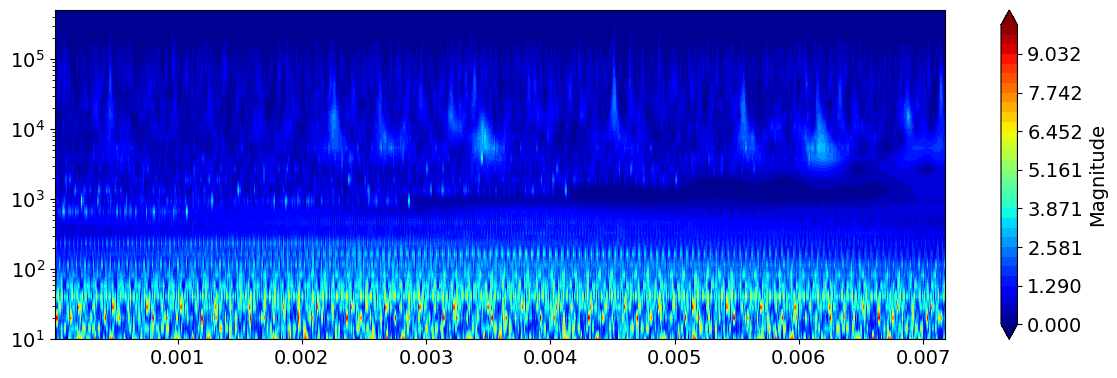

In [9]:
# Plot all segments' scalograms
fig, axs = plt.subplots(n_steps, 1, figsize=(12,4*n_steps))
# Ensure ax is always an array, even if only one subplot was created
axs = np.atleast_1d(axs)
axs = axs.flatten()

max_magnitude = 10
n_color_contours = 32
levels = np.linspace(0, max_magnitude, n_color_contours, endpoint=True)
for i, ax in enumerate(axs):
    seg_times, frequencies, abs_coeff = all_scalograms[i]
    contour = ax.contourf(seg_times, frequencies, abs_coeff, levels=levels, cmap='jet', extend='both')
    fig.colorbar(contour, ax=ax, label='Magnitude')
    ax.set_yscale('log')

# plt.colorbar(label='Magnitude')
# plt.ylabel('Frequency (Hz)')
# plt.xlabel('Time (s)')
# plt.title('Segmented Scalogram (Wavelet Transform)')
# plt.yscale('log')
plt.tight_layout()
plt.show()